## Предсказание пола клиента по транзакционным данным
[kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952) 

**Описание задачи**

Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях. В этом соревновании участникам предлагается ответить на вопрос: возможно ли предсказать пол клиента, используя сведения о поступлениях и тратах по банковской карте? И если возможно, то какая точность такого предсказания?

**Формальная постановка задачи**

Необходимо предсказать вероятность пола "1" для каждого "customerid", который присутствует в файле gender_test_kaggles_ample_submission.csv.

**Полезная информация**

Для понимания представленных данных будет полезна следующая [статья](https://www.banki.ru/wikibank/mcc-kod/)

**Метрика качества**

В качестве метрики качества предсказания была выбрана ROC AUC (area under the receiver operating characteristic curve).

**Описание датасета**

* customer_id - id пользователя
* tr_datetime - время транзакции
* mcc_code - код вида торговой точки
* tr_type - тип транзакции
* amount - налоговые обременения
* term_id - id терминала оплаты

* **gender - целевая переменная, пол**

In [3]:
# !pip install razdel pymorphy2 gensim nltk

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance
import shap
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import re
import numpy as np
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2 
import pickle

import nltk
nltk.download('stopwords')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Katrinka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def roc_auc(y_proba, y_true):
    '''
    Make a plot - ROC AUC curve, returns - area_under_curve value

    arguments:
    y_proba: numpy array - predicted probabilities 
    y_true: numpy array - true classes

    returns:
    area_under_curve: float
    '''

    TPR = []
    FPR = []
    tresholds = np.linspace(0, 1, 20)

    for treshold in tresholds:
        y_pred = np.where(y_proba >= treshold, 1, 0)

        TP = np.sum((y_true == y_pred) & (y_pred == 1))
        FP = np.sum((y_true != y_pred) & (y_pred == 1))
        TN = np.sum((y_true == y_pred) & (y_pred == 0))
        FN = np.sum((y_true != y_pred) & (y_pred == 0))

        tpr = TP / (TP + FN); TPR.append(tpr)
        fpr = FP / (FP + TN); FPR.append(fpr)

    area_under_curve = np.abs(np.trapz(TPR, FPR))
    x = np.linspace(0, 1, 50)
    y = x

    plt.figure(figsize=(10, 6))
    plt.plot(FPR, TPR, linewidth=1.5, color='#0B032D')
    plt.plot(x, y, linestyle='--', linewidth=1.5, color='#e36414')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve', size=20)

    return f'ROC AUC score = {area_under_curve:.4f}'

In [115]:
DATA_ROOT = Path('./data/')
MODELS_PATH = Path('./models/')

# input
TRANSACTIONS_DATASET_PATH = DATA_ROOT / 'transactions.csv'
GENDER_TRAIN_DATASET_PATH = DATA_ROOT / 'gender_train.csv'
MCC_DATASET_PATH = DATA_ROOT / 'tr_mcc_codes.csv'
TYPES_DATASET_PATH = DATA_ROOT / 'tr_types.csv'
Y_TEST = DATA_ROOT / 'gender_test_kaggle_sample_submission.csv'
STOP_WORDS = DATA_ROOT / 'stopwords.txt'

# output
PREPARED_TRAIN_DATASET_PATH = DATA_ROOT / 'train_prepared.csv'
PREPARED_TEST_DATASET_PATH = DATA_ROOT / 'test_prepared.csv'

MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

In [7]:
transactions = pd.read_csv(TRANSACTIONS_DATASET_PATH)
gender = pd.read_csv(GENDER_TRAIN_DATASET_PATH)
mcc = pd.read_csv(MCC_DATASET_PATH, sep=';')
types = pd.read_csv(TYPES_DATASET_PATH, sep=';')
test_id = pd.read_csv(Y_TEST)

df = pd.merge(transactions, gender, on='customer_id', how='left')


df_train = df.loc[df['customer_id'].isin(gender.customer_id.values)]
df_test = df.loc[df['customer_id'].isin(test_id.customer_id.values)]

### Обзор данных

**Обзор целевой переменной**

In [8]:
target_values = gender.gender.value_counts()
target_values

0    4687
1    3713
Name: gender, dtype: int64

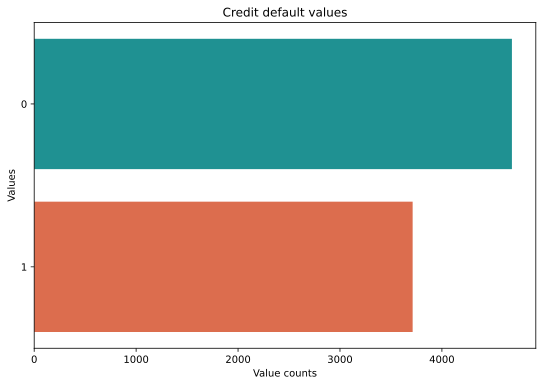

In [9]:
plt.figure(figsize=(9, 6))

sns.barplot(target_values.values, target_values.index, orient='h', palette=['#0CA4A5', '#F46036'])
plt.title('Credit default values')
plt.xlabel('Value counts')
plt.ylabel('Values')
plt.show()

In [10]:
disbalance = target_values[0] / target_values[1]
print(f'Количество наблюдений в обучающей выборке: {gender.gender.count()}',
      f'Количество наблюдений в тестовой выборке: {len(transactions.customer_id.unique()) - gender.gender.count()}',
      f'Дисбаланс целевой переменной: {disbalance:.2f}', sep='\n')

Количество наблюдений в обучающей выборке: 8400
Количество наблюдений в тестовой выборке: 6600
Дисбаланс целевой переменной: 1.26


**Обзор признаков**

In [11]:
df_train.head(7)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1.0
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,1.0
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,1.0
6,39026145,3 15:29:08,5499,1010,-1010.66,NaN,1.0


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751083 entries, 0 to 6849345
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   customer_id  int64  
 1   tr_datetime  object 
 2   mcc_code     int64  
 3   tr_type      int64  
 4   amount       float64
 5   term_id      object 
 6   gender       float64
dtypes: float64(2), int64(3), object(2)
memory usage: 228.9+ MB


In [13]:
df_train.isnull().sum()

customer_id          0
tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id        1519541
gender               0
dtype: int64

In [14]:
df_test.head(7)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender
3788,1645333,0 07:48:12,5411,1010,-28942.67,NaN,NaN
3789,1645333,6 06:48:03,5411,1010,-6256.90,NaN,NaN
3790,1645333,6 08:25:59,4814,1030,-1122.96,NaN,NaN
3791,1645333,6 14:17:44,5411,1010,-10821.72,NaN,NaN
3792,1645333,7 09:29:01,4829,2370,-46041.27,NaN,NaN
3793,1645333,7 09:29:24,6010,7070,46041.27,NaN,NaN
3794,1645333,7 09:50:55,5411,1010,-10005.78,NaN,NaN


In [15]:
df_test.isnull().sum()

customer_id          0
tr_datetime          0
mcc_code             0
tr_type              0
amount               0
term_id         664912
gender         1642254
dtype: int64

* `customer_id` - id пользователя, пропусков нет
* `tr_datetime` - тип данных object, пропусков в данных нет
* `mcc_code`, `tr_type` - тип данных int, пропусков нет, категории
* `amount` - тип данных float, положительные значения - начисление, отрицательные - списание, пропусков нет
* `term_id` - id терминала, почти треть данных - пропуски

Посмотрим, что из себя представляют коды MCC и коды транзакций, и на общее количество уникальных значений

In [16]:
mcc

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело
...,...,...
179,9211,"Судовые выплаты, включая алименты и детскую по..."
180,9222,Штрафы
181,9311,Налоговые платежи
182,9399,"Правительственные услуги, нигде ранее не класс..."


In [17]:
# число уникальных мсс-кодов
mcc.mcc_code.unique(), len(mcc.mcc_code.unique())

(array([ 742, 1711, 1731, 1799, 2741, 3000, 3351, 3501, 4111, 4112, 4121,
        4131, 4214, 4215, 4411, 4511, 4722, 4784, 4789, 4812, 4814, 4816,
        4829, 4899, 4900, 5013, 5039, 5044, 5045, 5047, 5065, 5072, 5074,
        5085, 5094, 5099, 5111, 5122, 5131, 5137, 5169, 5172, 5192, 5193,
        5199, 5200, 5211, 5231, 5251, 5261, 5300, 5309, 5310, 5311, 5331,
        5399, 5411, 5422, 5441, 5451, 5462, 5499, 5511, 5532, 5533, 5541,
        5542, 5571, 5599, 5611, 5621, 5631, 5641, 5651, 5655, 5661, 5681,
        5691, 5697, 5699, 5712, 5713, 5714, 5719, 5722, 5732, 5733, 5734,
        5735, 5811, 5812, 5813, 5814, 5816, 5912, 5921, 5931, 5940, 5941,
        5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5964, 5965,
        5967, 5968, 5969, 5970, 5971, 5976, 5977, 5983, 5992, 5993, 5994,
        5995, 5999, 6010, 6011, 6012, 6051, 6211, 6300, 6513, 6536, 7011,
        7210, 7216, 7221, 7230, 7273, 7278, 7298, 7299, 7311, 7338, 7372,
        7375, 7395, 7399, 7512, 7523, 

Все значения выглядят корректно, всего уникальных кодов - 184

In [18]:
types.sample(3)

,tr_type,tr_description
48,7031,Перевод на карту (с карты) через АТМ (из одног...
74,8050,Перевод средств с карты Visa Classic (E/M Stan...
127,2353,Погашение кредита с карты через Сбербанк ОнЛ@йн


In [19]:
# уникальные значения типов транзакций, число уникальных значений
types.tr_type.unique(), len(types.tr_type.unique())

(array([  3200,   3210,   3800,   4000,   4001,   4010,   4011,   4020,
          4021,   4030,   4031,   4040,   4041,   4050,   4051,   4052,
          4060,   4061,   4062,   4071,   4080,   4081,   4082,   4083,
          4100,   4110,   4200,   4210,   4400,   4440,   4500,   5110,
          6000,   6010,   6100,   6110,   6200,   6210,   7000,   7010,
          7011,   7014,   7015,   7020,   7021,   7024,   7025,   7030,
          7031,   7032,   7034,   7035,   7040,   7041,   7042,   7044,
          7045,   7050,   7060,   7070,   7071,   7074,   7075,   7081,
          7082,   7090,   7091,   7100,   7101,   8000,   8001,   8002,
          8003,   8035,   8050,   8100,   8140,   8145,   8150,   8151,
          8210,   8220,   8230,   1310,   1410,   1510,   2325,   2360,
          2440,   3300,   3810,   4035,   4045,   4090,   4600,   7084,
          8146,   1000,   1010,   1030,   1100,   1110,   1200,   1210,
          2000,   2001,   2010,   2011,   2020,   2021,   2100, 

Большинство значений выглядят корректно, есть непохожее на остальные значение 999999. Посмотрим, встречается ли оно в данных.

In [20]:
df.query('tr_type == 999999')

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender


Как видно, в данных такое значение не встречается

### Обработка данных

* `tr_datetime` - разделим на колонку на: 

    - `n_day` - номер дня  
    - `time` - время транзакции, сделаем формат datetime и сделаем дополнительные признаки час и время в секундах, чтобы перевести его в числовое представление  

In [21]:
df_train['tr_datetime'].values

array(['0 10:23:26', '1 10:19:29', '1 10:20:56', ..., '454 14:23:59',
       '454 16:11:53', '454 18:06:30'], dtype=object)

In [22]:
# колонка количества дней
df_train['n_day'] = np.array([int(el.split(' ')[0]) for el in df_train['tr_datetime'].values])
df_test['n_day'] = np.array([int(el.split(' ')[0]) for el in df_test['tr_datetime'].values])

# колонка месяца (возьмем усредненно 30 дней)
df_train['month'] = df_train['n_day'].values // 30
df_test['month'] = df_test['n_day'].values // 30

# колонка недели
df_train['week'] = df_train['n_day'].values // 7
df_test['week'] = df_test['n_day'].values // 7

# колонка времени
df_train['time'] = np.array([el.split(' ')[1] for el in df_train['tr_datetime'].values])
df_test['time'] = np.array([el.split(' ')[1] for el in df_test['tr_datetime'].values])

df_train.sample(n=5)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,n_day,month,week,time
1413844,6918821,311 00:00:00,6300,1100,-131407.63,NaN,0.0,311,10,44,00:00:00
2138703,2548573,75 08:46:13,5331,1010,-6333.48,NaN,1.0,75,2,10,08:46:13
4589068,42096,297 17:42:37,8999,1010,-2245.92,10244893,0.0,297,9,42,17:42:37
387978,70780820,112 15:03:13,6010,7070,9792.19,NaN,1.0,112,3,16,15:03:13
1255786,86889622,171 15:11:34,6010,7070,6815.23,NaN,0.0,171,5,24,15:11:34


In [23]:
# df_train['time'] = pd.to_datetime(df_train['time'])
# не срабатывает, так как есть неправильное время, напишем функцию для обработки этой колонки

def time_preprocessing(column, log=True):
    '''
    Time converting to seconds, outliers preprocessing, hour column
    ----------------------------------
    parameters:
    column: pandas Series, time column 
    log: bool, printing information about outliers
    
    returns:
    time_array: numpy array, time of transactions in seconds
    hours_array: numpy array, hour of transactions
    
    '''
    times = [time.split(':') for time in column]
    hour_err = 0; minutes_err = 0; second_err = 0; 
    time_in_seconds = []
    hours = []

    for time in times:
        if int(time[0]) > 23:
            hour_err += 1
            time[0] = 23
            errs.append(time)
        if int(time[1]) > 59:
            minutes_err += 1
            time[1] = 59
        if int(time[2]) > 59:
            second_err += 1
            time[1] = 59
        hours.append(int(time[0]))
        time = int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])
        time_in_seconds.append(time)

    time_array = np.array(time_in_seconds)
    hours_array = np.array(hours)

    if log:
        print(f'Всего ошибок:\nчасы:{hour_err}\nминуты: {minutes_err}\nсекунды: {second_err}')

    return time_array, hours_array 

In [24]:
df_train['time'], df_train['hour'] = time_preprocessing(df_train['time'])
df_train.head(3)

Всего ошибок:
часы:0
минуты: 0
секунды: 54333


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,n_day,month,week,time,hour
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,1.0,0,0,0,37406,10
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1.0,1,0,0,37169,10
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1.0,1,0,0,37256,10


In [25]:
df_test['time'], df_test['hour'] = time_preprocessing(df_test['time'])
df_test.tail(3)

Всего ошибок:
часы:0
минуты: 0
секунды: 24015


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,n_day,month,week,time,hour
6848192,66956350,455 10:50:16,5912,1010,-3189.20,978577,NaN,455,15,65,39016,10
6848193,66956350,456 09:28:35,5499,1010,-5367.74,928737,NaN,456,15,65,34115,9
6848194,66956350,456 15:58:49,5499,1010,-2486.45,928737,NaN,456,15,65,57529,15


Посмотрим, как распределяются затраты одного случайного пользователя за период использования банка

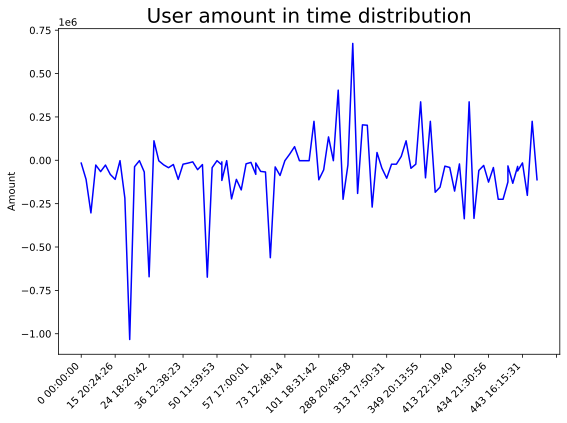

In [26]:
сustomer = df_train.query('customer_id == 61313305')['amount']
date = df_train.query('customer_id == 61313305')['tr_datetime']
days = df_train.query('customer_id == 61313305')['n_day'].argmax()

plt.figure(figsize =(9, 6))

plt.plot(date, сustomer, 'b' )
plt.title('User amount in time distribution', size=20 )
plt.ylabel('Amount')
plt.xticks(np.linspace(0, days, 15), rotation=45, ha='right')
plt.show()

Видно, что усредненно все приходит в ноль. Также встречаются большие транзакции. Сделаем из них дополнительный признак

* `mcc_code`

Посмотрим, есть ли отличия в кодах для разного пола

In [27]:
list_mcc1 = df_train.loc[df_train['gender']==1, 'mcc_code'].value_counts().nlargest(40).index
list_mcc0 = df_train.loc[df_train['gender']==0, 'mcc_code'].value_counts().nlargest(40).index
man = set(list_mcc1) - set(list_mcc0)
wom = set(list_mcc0) - set(list_mcc1)

In [28]:
mcc.loc[mcc['mcc_code'].isin(wom)]

,mcc_code,mcc_description
70,5621,Готовая женская одежда
73,5651,Одежда для всей семьи
79,5699,Различные магазины одежды и аксессуаров
99,5942,Книжные магазины
121,5995,Зоомагазины
171,8099,"Практикующие врачи, медицинские услуги, нигде ..."


In [29]:
mcc.loc[mcc['mcc_code'].isin(man)]

,mcc_code,mcc_description
21,4816,Компьютерная сеть/информационные услуги
64,5533,Автозапчасти и аксессуары
85,5732,Продажа электронного оборудования
91,5813,"Бары, коктейль-бары, дискотеки, ночные клубы и..."
161,7994,Галереи/учреждения видеоигр
162,7995,Транзакции по азартным играм


Видно, что очень хорошо делятся по смыслу, по-этому, можно сделать векторное представление пользователя с помощью этих кодов

In [31]:
mcc.tail(3)

,mcc_code,mcc_description
181,9311,Налоговые платежи
182,9399,"Правительственные услуги, нигде ранее не класс..."
183,9402,Почтовые услуги — только правительство


In [32]:
users_train = df_train.groupby('customer_id')['mcc_code'].apply(list).reset_index()
users_test = df_test.groupby('customer_id')['mcc_code'].apply(list).reset_index()
users_train.sample(5)

,customer_id,mcc_code
5905,70554895,"[6011, 6011, 7995, 5999, 7995, 6010, 4829, 601..."
2874,35118501,"[4814, 4814, 4814, 5499, 6011, 4814, 4814, 481..."
3159,38698737,"[8999, 6011, 4829, 6011, 4829, 4814, 4814, 599..."
5728,68617599,"[4814, 4814, 4814, 4814, 6011, 6011, 6011, 601..."
2623,32245326,"[5499, 4814, 5977, 5912, 4814, 5661, 5977, 597..."


Получим векторное представление пользователя на основе mcc кодов его покупок

In [33]:
# загружаем стоп-слова Русского языка 
stopword_ru = stopwords.words('russian')

# создаем морфологический анализатор (экземпляр класса)
morph = pymorphy2.MorphAnalyzer()

# добавим к стоп-словам еще один список из  файла

with open(STOP_WORDS) as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

len(stopword_ru)

779

In [34]:
def clean_text(text):
    '''
    Очистка текста
    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.strip('\n').strip('\r').strip('\t').replace("/", " ")
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))
    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
    0 если зашел тип не `str` делаем его `str`
    1 токенизация предложения через razdel
    2 проверка есть ли в начале слова '-'
    3 проверка токена с одного символа
    4 проверка есть ли данное слово в кэше
    5 лемматизация слова
    6 проверка на стоп-слова

    Возвращает лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form # приводим слово к нормальной форме
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [35]:
# делаем очистку и токенизацию заголовков MCC кодов
mcc['mcc_description'] = mcc['mcc_description'].apply(lambda x: clean_text(x), 1)
mcc['mcc_description'] = mcc['mcc_description'].apply(lambda x: lemmatization(x), 1)
mcc

,mcc_code,mcc_description
0,742,"[ветеринарный, услуга]"
1,1711,"[генеральный, подрядчик, вентиляция, теплоснаб..."
2,1731,"[подрядчик, электричество]"
3,1799,"[подрядчик, специализировать, торговля, класси..."
4,2741,"[разнообразный, издательство, печатный]"
...,...,...
179,9211,"[судовой, выплата, алименты, детский, поддержка]"
180,9222,[штраф]
181,9311,"[налоговый, платёж]"
182,9399,"[правительственный, услуга, классифицировать]"


In [36]:
texts = [t for t in mcc['mcc_description'].values]
# создаем словарь из всех встречающихся в датасете слов 
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
common_dictionary[20]

'курорт'

In [37]:
common_dictionary.id2token

{0: 'ветеринарный',
 1: 'услуга',
 2: 'вентиляция',
 3: 'водопровод',
 4: 'генеральный',
 5: 'подрядчик',
 6: 'теплоснабжение',
 7: 'электричество',
 8: 'классифицировать',
 9: 'специализировать',
 10: 'торговля',
 11: 'издательство',
 12: 'печатный',
 13: 'разнообразный',
 14: 'авиакомпания',
 15: 'авиалиния',
 16: 'автомобиль',
 17: 'агентство',
 18: 'аренда',
 19: 'жильё',
 20: 'курорт',
 21: 'мотель',
 22: 'отель',
 23: 'локальный',
 24: 'пригородный',
 25: 'сезонный',
 26: 'средство',
 27: 'транспортировка',
 28: 'транспортный',
 29: 'электричка',
 30: 'железный',
 31: 'пассажирский',
 32: 'перевозка',
 33: 'лимузин',
 34: 'такси',
 35: 'автобусный',
 36: 'линия',
 37: 'автогрузоперевозка',
 38: 'автотранспортный',
 39: 'дальный',
 40: 'доставка',
 41: 'местный',
 42: 'попереезд',
 43: 'хранение',
 44: 'воздух',
 45: 'груз',
 46: 'земля',
 47: 'курьер',
 48: 'отправка',
 49: 'круизный',
 50: 'организатор',
 51: 'туристический',
 52: 'экскурсия',
 53: 'дорожный',
 54: 'мостовая',
 

In [38]:
N_topic = 25 # число тем - гиперпараметр
# модель, которая делает разбивку по темам 
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, random_state=42, passes=10)

x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: продажа премия гарантировать размещение снятие институт наличность страхование вручную финансовый обслуживание производство веломагазин дистрибуция видеофильм
topic_1: медицинский розница молочный продажа продукт зубной автомобиль агентство аренда лаборатория видеоигра станция техобслуживание принадлежность практиковать
topic_2: классифицировать письмо сопутствовать бумага товар офисный канцелярия печатание кожаный принадлежность дорожный магазин изделие химикалии смежный
topic_3: продажа туристический дискотека алкогольный коктейльбара напиток таверна клуб место ночной бар прямой организатор duty каталог
topic_4: ремонт магазин продажа фотостудия пиво спиртной ликёр вино вынос напиток техника бытовой электроприбор фотоприбор фотооборудование
topic_5: ресторан отдых гардина жалюзи обивочный портьера база сервис бронирование отель ткань материал мотель книга газета
topic_6: оборудование ткань электрооборудование мебель нитка рукоделие принадлежность бытовой магазин шитьё электр

In [39]:
# переразмечаем темы, то есть каждому mcc будет соответствовать индекс lda тем (вероятности)
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [40]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in mcc['mcc_description'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['mcc_code'] = mcc['mcc_code'].values
topic_matrix = topic_matrix[['mcc_code']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,mcc_code,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,742,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333
1,1711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.839998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1731,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.679997,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333
3,1799,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2741,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.759998,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000


In [41]:
doc_dict = dict(zip(topic_matrix['mcc_code'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

def get_user_embedding(user_articles_list):
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.mean(user_vector, 0) 
    
    return user_vector1 

In [42]:
user_train = pd.DataFrame([i for i in users_train['mcc_code'].apply(lambda x: get_user_embedding(x), 1)])
user_train.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_train['customer_id'] = users_train['customer_id'].values
user_train = user_train[['customer_id']+['topic_{}'.format(i) for i in range(N_topic)]]

user_test = pd.DataFrame([i for i in users_test['mcc_code'].apply(lambda x: get_user_embedding(x), 1)])
user_test.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_test['customer_id'] = users_test['customer_id'].values
user_test = user_test[['customer_id']+['topic_{}'.format(i) for i in range(N_topic)]]
user_test

,customer_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6815,0.071725,0.003850,0.003850,0.003850,0.011755,0.003850,0.003850,0.003850,0.100088,...,0.003850,0.003850,0.282610,0.003850,0.003850,0.003850,0.003850,0.003850,0.003850,0.003850
1,27914,0.015796,0.006667,0.000661,0.000661,0.000661,0.000661,0.032192,0.000661,0.000661,...,0.000661,0.000661,0.341201,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661
2,31385,0.027078,0.004064,0.004064,0.004064,0.004064,0.005890,0.007717,0.011757,0.262967,...,0.004064,0.005434,0.165160,0.004064,0.004980,0.004064,0.018447,0.006278,0.004974,0.009782
3,38084,0.036222,0.006250,0.006418,0.008492,0.006506,0.010810,0.073914,0.041541,0.161617,...,0.005718,0.033554,0.119541,0.011320,0.006426,0.005718,0.015172,0.010662,0.008647,0.012176
4,78659,0.040867,0.004002,0.004002,0.014134,0.004002,0.004002,0.041097,0.004002,0.123124,...,0.004002,0.004002,0.088493,0.004002,0.006353,0.004002,0.004002,0.004002,0.004002,0.018109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,99918216,0.005213,0.124078,0.005213,0.034333,0.009965,0.005213,0.005213,0.254149,0.056631,...,0.005213,0.026489,0.076702,0.005213,0.025250,0.005213,0.005213,0.013809,0.015194,0.010764
3596,99938948,0.061493,0.003733,0.004784,0.008052,0.009369,0.007110,0.019506,0.034547,0.138196,...,0.003733,0.015563,0.268717,0.008465,0.010042,0.003733,0.003733,0.003733,0.003733,0.008312
3597,99953525,0.078488,0.011124,0.005233,0.005233,0.005233,0.009109,0.059980,0.005233,0.227616,...,0.009930,0.019767,0.342209,0.005233,0.013076,0.005233,0.005233,0.005233,0.009095,0.005233
3598,99985917,0.043167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.038667,...,0.001167,0.001167,0.673165,0.001167,0.001167,0.001167,0.001167,0.034500,0.001167,0.001167


* `tr_type`

In [43]:
types.tail(3)

,tr_type,tr_description
152,3001,Комиссия за обслуживание ссудного счета
153,3030,Плата за обслуживание банковской карты (за пос...
154,3120,Плата за досрочный перевыпуск карты


In [44]:
users_train = df_train.groupby('customer_id')['tr_type'].apply(list).reset_index()
users_test = df_test.groupby('customer_id')['tr_type'].apply(list).reset_index()

users_train.sample(5)

,customer_id,tr_type
1910,23603973,"[7010, 2330, 7030, 2010, 7031, 2010, 1030, 103..."
2823,34580044,"[2010, 1030, 7070, 1030, 7070, 2010, 2010, 201..."
4015,48555373,"[1110, 1010, 1110, 7010, 1010, 1010, 1010, 101..."
4752,57299055,"[7010, 1030, 2010, 2010, 7010, 1030, 2010, 707..."
4430,53411904,"[1030, 1030, 2010, 1030, 2010, 1030, 1030, 201..."


In [45]:
types['tr_description'] = types['tr_description'].apply(lambda x: clean_text(x), 1)
types['tr_description'] = types['tr_description'].apply(lambda x: lemmatization(x), 1)

In [46]:
texts = [t for t in types['tr_description'].values]
# создаем словарь из всех встречающихся в датасете слов 
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
common_dictionary[10]

'банковский'

In [47]:
common_dictionary.id2token

{0: 'мобильный',
 1: 'плата',
 2: 'посредством',
 3: 'предоставление',
 4: 'связь',
 5: 'услуга',
 6: 'карта',
 7: 'отчёт',
 8: 'почта',
 9: 'счёт',
 10: 'банковский',
 11: 'обслуживание',
 12: 'первый',
 13: 'наличный',
 14: 'получение',
 15: 'сбербанк',
 16: 'тб',
 17: 'атм',
 18: 'pos',
 19: 'взнос',
 20: 'тербанка',
 21: 'друг',
 22: 'перевод',
 23: 'предел',
 24: 'филиал',
 25: 'банк',
 26: 'всп',
 27: 'оплата',
 28: 'онлйн',
 29: 'автомат',
 30: 'поручение',
 31: 'россия',
 32: 'зарубеж',
 33: 'баланс',
 34: 'чужой',
 35: 'выписка',
 36: 'операция',
 37: 'последний',
 38: 'превышлимит',
 39: 'овердрафт',
 40: 'списание',
 41: 'возврат',
 42: 'покупка',
 43: 'рф',
 44: 'сб',
 45: 'подразды',
 46: 'пополнение',
 47: 'взимание',
 48: 'комиссия',
 49: 'отправитель',
 50: 'причислить',
 51: 'сумма',
 52: 'задолженность',
 53: 'погашение',
 54: 'бп',
 55: 'ус',
 56: 'интернет',
 57: 'зарплатный',
 58: 'межфилиальный',
 59: 'перечисление',
 60: 'зачислый',
 61: 'клиена',
 62: 'поправка'

По последним токенам видно, что скорее всего, они не приведут к нужному разделению.

* `amount` - траты за день, пополнения, зачисления на месяц, траты в месяц, за неделю

In [48]:
# колонка затрат
df_train['spent'] = np.where(df_train['amount'].values < 0, abs(df_train['amount'].values), 0)
df_test['spent'] = np.where(df_test['amount'].values < 0, abs(df_test['amount'].values), 0)

# колонка пополнений
df_train['income'] = np.where(df_train['amount'].values > 0, df_train['amount'].values, 0)
df_test['income'] = np.where(df_test['amount'].values > 0, df_test['amount'].values, 0)

In [49]:
# всего потрачено за месяц
def spent_for_a_month(df):
    gp = df.groupby(['customer_id', 'month'])['spent'].sum().rename('spent_for_a_month', inplace=True)
    df = pd.merge(df, gp, on=['customer_id', 'month'], how="left")
    return df

# всего потрачено за неделю
def spent_for_a_week(df):
    gp = df.groupby(['customer_id', 'week'])['spent'].sum().rename('spent_for_a_week', inplace=True)
    df = pd.merge(df, gp, on=['customer_id', 'week'], how="left")
    return df

# всего получено за месяц
def income_for_a_month(df):
    gp = df.groupby(['customer_id', 'month'])['income'].sum().rename('income_for_a_month', inplace=True)
    df = pd.merge(df, gp, on=['customer_id', 'month'], how="left")
    return df

In [50]:
df_train = spent_for_a_month(df_train)
df_test = spent_for_a_month(df_test)

df_train = spent_for_a_week(df_train)
df_test = spent_for_a_week(df_test)

df_train = income_for_a_month(df_train)
df_test = income_for_a_month(df_test)

# разница полученного и потраченного (может быть долг или накопления)
df_train['diff_income_spent'] = df_train['income'] - df_train['spent']
df_test['diff_income_spent'] = df_test['income'] - df_test['spent']

# есть ли задолженность
df_train['dept'] = np.where(df_train['diff_income_spent'] < 0, 1, 0)
df_test['dept'] = np.where(df_test['diff_income_spent'] < 0, 1, 0)

In [51]:
gp = df_train.groupby('customer_id').agg({'spent_for_a_month': [('min_spent_for_a_month', 'min'),
                                                    ('max_spent_for_a_month', 'max'), 
                                                    ('mean_spent_for_a_month', 'mean')],
                                         'spent_for_a_week': [('min_spent_for_a_week', 'min'),
                                                    ('max_spent_for_a_week', 'max'), 
                                                    ('mean_spent_for_a_week', 'mean')],
                                         'income_for_a_month': [('min_income_for_a_month', 'min'),
                                                    ('max_income_for_a_month', 'max'), 
                                                    ('mean_income_for_a_month', 'mean')]})
df_train = pd.merge(df_train, gp, on='customer_id', how='left')

gp = df_test.groupby('customer_id').agg({'spent_for_a_month': [('min_spent_for_a_month', 'min'),
                                                    ('max_spent_for_a_month', 'max'), 
                                                    ('mean_spent_for_a_month', 'mean')],
                                         'spent_for_a_week': [('min_spent_for_a_week', 'min'),
                                                    ('max_spent_for_a_week', 'max'), 
                                                    ('mean_spent_for_a_week', 'mean')],
                                         'income_for_a_month': [('min_income_for_a_month', 'min'),
                                                    ('max_income_for_a_month', 'max'), 
                                                    ('mean_income_for_a_month', 'mean')]})
df_test = pd.merge(df_test, gp, on='customer_id', how='left')
df_test

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,n_day,month,week,...,dept,"(spent_for_a_month, min_spent_for_a_month)","(spent_for_a_month, max_spent_for_a_month)","(spent_for_a_month, mean_spent_for_a_month)","(spent_for_a_week, min_spent_for_a_week)","(spent_for_a_week, max_spent_for_a_week)","(spent_for_a_week, mean_spent_for_a_week)","(income_for_a_month, min_income_for_a_month)","(income_for_a_month, max_income_for_a_month)","(income_for_a_month, mean_income_for_a_month)"
0,1645333,0 07:48:12,5411,1010,-28942.67,NaN,NaN,0,0,0,...,1,288057.13,1801025.30,927554.585612,898.37,827393.83,279437.080768,1248.06,643846.78,193744.122669
1,1645333,6 06:48:03,5411,1010,-6256.90,NaN,NaN,6,0,0,...,1,288057.13,1801025.30,927554.585612,898.37,827393.83,279437.080768,1248.06,643846.78,193744.122669
2,1645333,6 08:25:59,4814,1030,-1122.96,NaN,NaN,6,0,0,...,1,288057.13,1801025.30,927554.585612,898.37,827393.83,279437.080768,1248.06,643846.78,193744.122669
3,1645333,6 14:17:44,5411,1010,-10821.72,NaN,NaN,6,0,0,...,1,288057.13,1801025.30,927554.585612,898.37,827393.83,279437.080768,1248.06,643846.78,193744.122669
4,1645333,7 09:29:01,4829,2370,-46041.27,NaN,NaN,7,0,1,...,1,288057.13,1801025.30,927554.585612,898.37,827393.83,279437.080768,1248.06,643846.78,193744.122669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642249,66956350,454 12:55:35,4814,1030,-449.18,888924,NaN,454,15,64,...,1,19850.30,404927.39,170787.947787,224.59,194727.63,56514.755464,0.00,345871.03,75306.906093
1642250,66956350,455 10:46:01,5411,1010,-4963.47,862783,NaN,455,15,65,...,1,19850.30,404927.39,170787.947787,224.59,194727.63,56514.755464,0.00,345871.03,75306.906093
1642251,66956350,455 10:50:16,5912,1010,-3189.20,978577,NaN,455,15,65,...,1,19850.30,404927.39,170787.947787,224.59,194727.63,56514.755464,0.00,345871.03,75306.906093
1642252,66956350,456 09:28:35,5499,1010,-5367.74,928737,NaN,456,15,65,...,1,19850.30,404927.39,170787.947787,224.59,194727.63,56514.755464,0.00,345871.03,75306.906093


In [52]:
cols = ['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount',
        'term_id', 'gender', 'n_day', 'month', 'week', 'time','hour',
        'spent', 'income', 'spent_for_a_month', 'spent_for_a_week', 
        'income_for_a_month', 'diff_income_spent', 'dept', 'min_spent_for_a_month', 
        'max_spent_for_a_month', 'mean_spent_for_a_month', 'min_spent_for_a_week',
        'max_spent_for_a_week', 'mean_spent_for_a_week', 'min_income_for_a_month',
        'max_income_for_a_month', 'mean_income_for_a_month']

In [53]:
df_train.columns = cols
df_test.columns = cols

In [54]:
df_train['more_tran_mean'] = np.where(df_train['mean_spent_for_a_month'] > 1e9, 1, 0)
df_test['more_tran_mean'] = np.where(df_test['mean_spent_for_a_month'] > 1e9, 1, 0)

In [55]:
# средняя цена за покупку у пользователя
def median_purchase(df):
    gp = df.groupby('customer_id')['spent'].median().rename('median_purchase', inplace=True)
    df = pd.merge(df, gp, on=['customer_id'], how="left")
    return df

# если цена превышает пользовательскую среднюю, то будем считать покупку дорогой
def expensive(df):
    df['more_than_median'] = df['amount'] - df['median_purchase']
    df['expencive'] = np.where(df['more_than_median'].values > 0, 1, 0)
    return df

# посчитаем количество дорогих покупок для пользователя
def number_of_expensive(df):
    gp = df.groupby('customer_id')['expencive'].sum().rename('number_of_expensive', inplace=True)
    df = pd.merge(df, gp, on=['customer_id'], how="left")
    return df

In [56]:
df_train = median_purchase(df_train)
df_test = median_purchase(df_test)

df_train = expensive(df_train)
df_test = expensive(df_test)

df_train = number_of_expensive(df_train)
df_test = number_of_expensive(df_test)

In [57]:
df_train.columns

Index(['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount',
       'term_id', 'gender', 'n_day', 'month', 'week', 'time', 'hour', 'spent',
       'income', 'spent_for_a_month', 'spent_for_a_week', 'income_for_a_month',
       'diff_income_spent', 'dept', 'min_spent_for_a_month',
       'max_spent_for_a_month', 'mean_spent_for_a_month',
       'min_spent_for_a_week', 'max_spent_for_a_week', 'mean_spent_for_a_week',
       'min_income_for_a_month', 'max_income_for_a_month',
       'mean_income_for_a_month', 'more_tran_mean', 'median_purchase',
       'more_than_median', 'expencive', 'number_of_expensive'],
      dtype='object')

* `term_id` - обработка пропусков (лучше убрать?)

In [58]:
df_train.term_id.value_counts()

888991      40451
888990      40367
888986      40357
888992      40338
888987      40111
            ...  
10182038        1
694765          1
10186422        1
372800          1
37763302        1
Name: term_id, Length: 311690, dtype: int64

In [59]:
df_train.term_id.isnull().sum()

1519541

In [60]:
df_train.drop(columns=['term_id', 'tr_datetime'], inplace=True)
df_test.drop(columns=['term_id', 'tr_datetime'], inplace=True)

### Сохранение обучающего датасета

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751083 entries, 0 to 3751082
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   customer_id              int64  
 1   mcc_code                 int64  
 2   tr_type                  int64  
 3   amount                   float64
 4   gender                   float64
 5   n_day                    int64  
 6   month                    int64  
 7   week                     int64  
 8   time                     int64  
 9   hour                     int64  
 10  spent                    float64
 11  income                   float64
 12  spent_for_a_month        float64
 13  spent_for_a_week         float64
 14  income_for_a_month       float64
 15  diff_income_spent        float64
 16  dept                     int64  
 17  min_spent_for_a_month    float64
 18  max_spent_for_a_month    float64
 19  mean_spent_for_a_month   float64
 20  min_spent_for_a_week     float64
 21  max_spen

In [62]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1642254 entries, 0 to 1642253
Data columns (total 31 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   customer_id              1642254 non-null  int64  
 1   mcc_code                 1642254 non-null  int64  
 2   tr_type                  1642254 non-null  int64  
 3   amount                   1642254 non-null  float64
 4   gender                   0 non-null        float64
 5   n_day                    1642254 non-null  int64  
 6   month                    1642254 non-null  int64  
 7   week                     1642254 non-null  int64  
 8   time                     1642254 non-null  int64  
 9   hour                     1642254 non-null  int64  
 10  spent                    1642254 non-null  float64
 11  income                   1642254 non-null  float64
 12  spent_for_a_month        1642254 non-null  float64
 13  spent_for_a_week         1642254 non-null 

In [63]:
user_train

,customer_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,22899,0.103020,0.025299,0.002507,0.002507,0.002507,0.002507,0.079430,0.062507,0.024587,...,0.002507,0.008097,0.354301,0.002507,0.002507,0.002507,0.002507,0.002507,0.002507,0.002507
1,28753,0.138072,0.023129,0.007801,0.013297,0.010549,0.130249,0.087732,0.014168,0.058821,...,0.007801,0.019705,0.102086,0.010068,0.014909,0.009501,0.043231,0.017460,0.013297,0.011350
2,42096,0.078558,0.004434,0.005146,0.007024,0.006160,0.008775,0.030399,0.035434,0.127119,...,0.004434,0.028139,0.281170,0.004434,0.039693,0.004434,0.008440,0.010326,0.005143,0.010368
3,49793,0.023535,0.001274,0.001274,0.002573,0.003015,0.001274,0.011670,0.510326,0.046595,...,0.001274,0.003823,0.147277,0.001274,0.001274,0.001274,0.002736,0.001274,0.001274,0.001274
4,50940,0.093333,0.000791,0.000791,0.000791,0.053785,0.006441,0.000791,0.000791,0.026215,...,0.000791,0.009266,0.641468,0.000791,0.000791,0.000791,0.000791,0.000791,0.000791,0.000791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,99917144,0.009179,0.009179,0.009179,0.009179,0.009179,0.009179,0.009179,0.009179,0.634924,...,0.009179,0.012164,0.093179,0.009179,0.009179,0.009179,0.009179,0.009179,0.009179,0.012294
8396,99967537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.516922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8397,99984336,0.027354,0.000688,0.000688,0.000688,0.000688,0.000688,0.000688,0.000688,0.012593,...,0.000688,0.008624,0.774020,0.000688,0.000688,0.000688,0.000688,0.000688,0.000688,0.000688
8398,99988578,0.109548,0.008031,0.006416,0.004802,0.006965,0.014023,0.099031,0.092550,0.138277,...,0.004802,0.009040,0.166497,0.004802,0.038600,0.004802,0.004802,0.005781,0.005868,0.011455


In [64]:
user_test

,customer_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6815,0.071725,0.003850,0.003850,0.003850,0.011755,0.003850,0.003850,0.003850,0.100088,...,0.003850,0.003850,0.282610,0.003850,0.003850,0.003850,0.003850,0.003850,0.003850,0.003850
1,27914,0.015796,0.006667,0.000661,0.000661,0.000661,0.000661,0.032192,0.000661,0.000661,...,0.000661,0.000661,0.341201,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661
2,31385,0.027078,0.004064,0.004064,0.004064,0.004064,0.005890,0.007717,0.011757,0.262967,...,0.004064,0.005434,0.165160,0.004064,0.004980,0.004064,0.018447,0.006278,0.004974,0.009782
3,38084,0.036222,0.006250,0.006418,0.008492,0.006506,0.010810,0.073914,0.041541,0.161617,...,0.005718,0.033554,0.119541,0.011320,0.006426,0.005718,0.015172,0.010662,0.008647,0.012176
4,78659,0.040867,0.004002,0.004002,0.014134,0.004002,0.004002,0.041097,0.004002,0.123124,...,0.004002,0.004002,0.088493,0.004002,0.006353,0.004002,0.004002,0.004002,0.004002,0.018109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,99918216,0.005213,0.124078,0.005213,0.034333,0.009965,0.005213,0.005213,0.254149,0.056631,...,0.005213,0.026489,0.076702,0.005213,0.025250,0.005213,0.005213,0.013809,0.015194,0.010764
3596,99938948,0.061493,0.003733,0.004784,0.008052,0.009369,0.007110,0.019506,0.034547,0.138196,...,0.003733,0.015563,0.268717,0.008465,0.010042,0.003733,0.003733,0.003733,0.003733,0.008312
3597,99953525,0.078488,0.011124,0.005233,0.005233,0.005233,0.009109,0.059980,0.005233,0.227616,...,0.009930,0.019767,0.342209,0.005233,0.013076,0.005233,0.005233,0.005233,0.009095,0.005233
3598,99985917,0.043167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.001167,0.038667,...,0.001167,0.001167,0.673165,0.001167,0.001167,0.001167,0.001167,0.034500,0.001167,0.001167


In [65]:
# совмещаем все, что нужно

cols_for_merge = ['gender', 'diff_income_spent', 'dept', 'min_spent_for_a_month',
       'max_spent_for_a_month', 'mean_spent_for_a_month',
       'min_spent_for_a_week', 'max_spent_for_a_week', 'mean_spent_for_a_week',
       'min_income_for_a_month', 'max_income_for_a_month',
       'mean_income_for_a_month', 'more_tran_mean', 'median_purchase',
       'more_than_median', 'expencive', 'number_of_expensive']

gp_train = df_train.groupby('customer_id')[cols_for_merge].mean()
gp_test = df_test.groupby('customer_id')[cols_for_merge].mean()

full_train = pd.merge(gp_train, user_train, on='customer_id', how='left')
full_test = pd.merge(gp_test, user_test, on='customer_id', how='left')

In [66]:
def save(df, PATH):
    df.to_csv(PATH, index=False, encoding='utf-8', sep=';')

In [67]:
save(full_train, PREPARED_TRAIN_DATASET_PATH)
save(full_test, PREPARED_TEST_DATASET_PATH)

In [68]:
full_train.head(3)

,customer_id,gender,diff_income_spent,dept,min_spent_for_a_month,max_spent_for_a_month,mean_spent_for_a_month,min_spent_for_a_week,max_spent_for_a_week,mean_spent_for_a_week,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,22899,1.0,-2691.438419,0.709402,38060.19,1295144.40,5.635170e+05,0.00,884593.23,1.680275e+05,...,0.002507,0.008097,0.354301,0.002507,0.002507,0.002507,0.002507,0.002507,0.002507,0.002507
1,28753,0.0,-90293.479116,0.829932,6737.75,12603858.27,6.238651e+06,0.00,9358307.90,2.022265e+06,...,0.007801,0.019705,0.102086,0.010068,0.014909,0.009501,0.043231,0.017460,0.013297,0.011350
2,42096,0.0,-5907.505855,0.929487,113980.90,1518321.93,1.101779e+06,8983.66,723103.13,2.703861e+05,...,0.004434,0.028139,0.281170,0.004434,0.039693,0.004434,0.008440,0.010326,0.005143,0.010368


Посмотрим на связь признаков с целевой переменной.

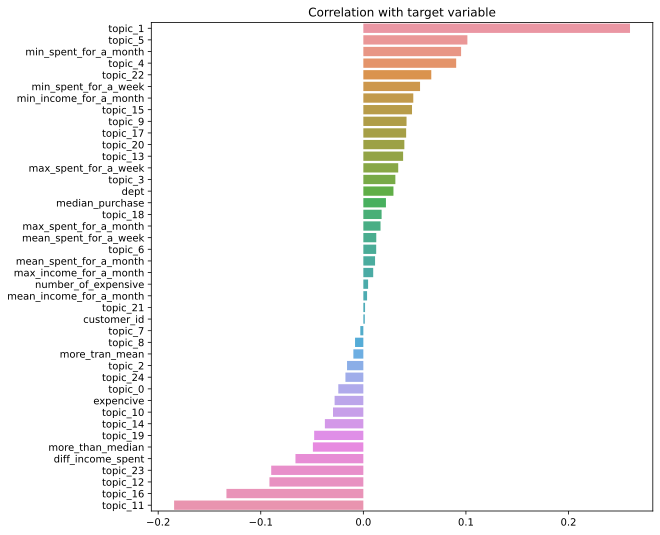

In [69]:
#Корелляция с базовыми признаками

TARGET = 'gender'
FEATURES = full_train.columns.drop(TARGET).tolist()

corr_with_target = full_train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(9, 9))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видно, что более сильное влияние на целевую переменную оказывают темы, на которые мы разбили пользователей в соответствиии и их покупками.
Посмотрим на распределения числовых значений в засисимости от целевой переменной

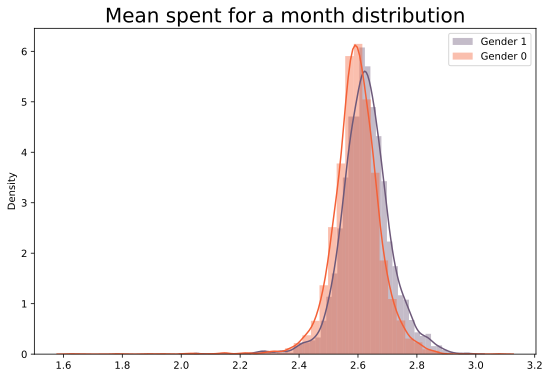

In [70]:
spent_1 = np.log(full_train.loc[full_train['gender'] == 1, 'mean_spent_for_a_month'].values)
spent_2 = np.log(full_train.loc[full_train['gender'] == 0, 'mean_spent_for_a_month'].values)

plt.figure(figsize = (9, 6))

sns.distplot(np.log(spent_1), color='#6D597A', label='Gender 1' )
sns.distplot(np.log(spent_2), color='#F46036', label='Gender 0')

plt.title('Mean spent for a month distribution', size=20)

plt.legend()
plt.show()

Видно, что этот признак плохо разделяет выборки, возможно его лучше удалить из обучения. Посмотрим, какая ситуация с поступлением денег на баланс

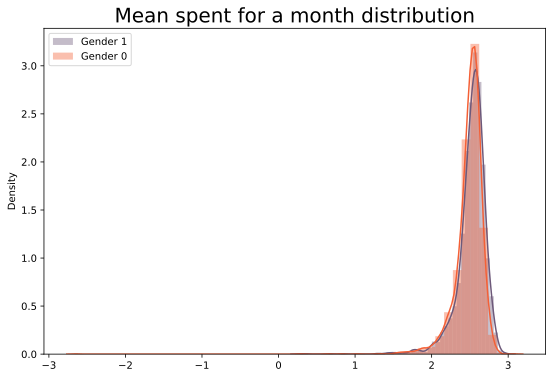

In [71]:
spent_1 = np.log(full_train.loc[full_train['gender'] == 1, 'mean_income_for_a_month'].values)
spent_2 = np.log(full_train.loc[full_train['gender'] == 0, 'mean_income_for_a_month'].values)

plt.figure(figsize = (9, 6))

sns.distplot(np.log(spent_1), color='#6D597A', label='Gender 1' )
sns.distplot(np.log(spent_2), color='#F46036', label='Gender 0')

plt.title('Mean spent for a month distribution', size=20)

plt.legend()
plt.show()

In [72]:
full_train.columns

Index(['customer_id', 'gender', 'diff_income_spent', 'dept',
       'min_spent_for_a_month', 'max_spent_for_a_month',
       'mean_spent_for_a_month', 'min_spent_for_a_week',
       'max_spent_for_a_week', 'mean_spent_for_a_week',
       'min_income_for_a_month', 'max_income_for_a_month',
       'mean_income_for_a_month', 'more_tran_mean', 'median_purchase',
       'more_than_median', 'expencive', 'number_of_expensive', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12',
       'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
       'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24'],
      dtype='object')

### Разбиение на обучающую и отложенную выборку

In [92]:
X_train, X_test, y_train, y_test = train_test_split(full_train.drop(columns=['gender']), full_train['gender'], 
                                    shuffle=True, test_size=0.25, stratify=full_train['gender'], 
                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6300, 42), (2100, 42), (6300,), (2100,))

### Выделение целевой переменной и групп признаков

In [93]:
X_train.columns

Index(['customer_id', 'diff_income_spent', 'dept', 'min_spent_for_a_month',
       'max_spent_for_a_month', 'mean_spent_for_a_month',
       'min_spent_for_a_week', 'max_spent_for_a_week', 'mean_spent_for_a_week',
       'min_income_for_a_month', 'max_income_for_a_month',
       'mean_income_for_a_month', 'more_tran_mean', 'median_purchase',
       'more_than_median', 'expencive', 'number_of_expensive', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12',
       'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
       'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24'],
      dtype='object')

In [94]:
TARGET = 'gender'

FEATURES = ['diff_income_spent', 'dept', 'min_spent_for_a_month',
            'max_spent_for_a_month', 'min_spent_for_a_week', 'max_spent_for_a_week', 
            'mean_spent_for_a_week',
#             'min_income_for_a_month',
#             'mean_spent_for_a_month',
            'max_income_for_a_month',
#             'mean_income_for_a_month',
#             'more_tran_mean', 
            'median_purchase', 'more_than_median', 'expencive', 'number_of_expensive', 
            'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 
            'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 
            'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
            'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24']


X = full_train[FEATURES]
y = full_train[TARGET]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

In [76]:
def get_report(y_train_true, y_train_prob, y_test_true, y_test_prob):
    print(f'TRAIN: {roc_auc_score(y_train_true, y_train_prob)}')
    print(f'TEST:  {roc_auc_score(y_test_true, y_test_prob)}')

In [95]:
# модель Catboost

catb = CatBoostClassifier(learning_rate=0.08,
                          n_estimators=350,
                          depth=4,
                          class_weights=[1, disbalance],
                          silent=True,                           
                          random_state=21)

catb.fit(X_train, y_train)

In [96]:
y_train_prob  = catb.predict_proba(X_train)[:, 1]
y_test_prob = catb.predict_proba(X_test)[:, 1]

In [97]:
get_report(y_train, y_train_prob,
           y_test, y_test_prob)

TRAIN: 0.9276628248772254
TEST:  0.8152040793809581


'ROC AUC score = 0.9264'

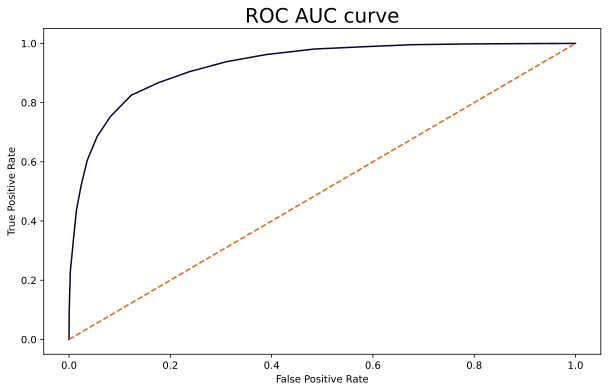

In [98]:
roc_auc(y_train_prob, y_train)

'ROC AUC score = 0.8155'

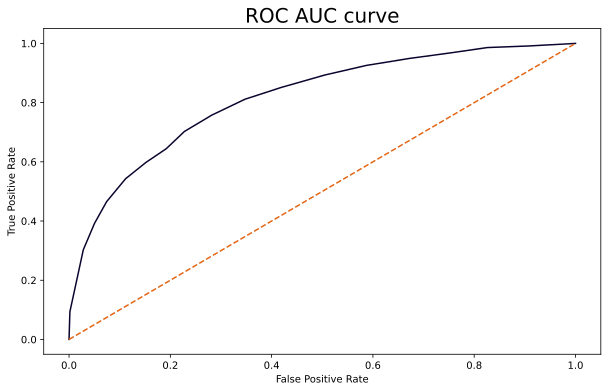

In [99]:
roc_auc(y_test_prob, y_test)

In [100]:
# модель lightGBM

light = LGBMClassifier(n_estimators=300,
                        boosting_type='dart',
                        max_depth=3,
                        learning_rate=0.25,
                        class_weight = {0:1, 1:disbalance},
                        random_state=21)

light.fit(X_train, y_train)

y_train_prob  = light.predict_proba(X_train)[:, 1]
y_test_prob = light.predict_proba(X_test)[:, 1]

get_report(y_train, y_train_prob, y_test, y_test_prob)

# users_train = train.groupby('customer_id')['gender', 'predict_proba'].mean()
# users_valid = valid.groupby('customer_id')['gender', 'predict_proba'].mean()

TRAIN: 0.9247299723421806
TEST:  0.8070679357420266


'ROC AUC score = 0.9237'

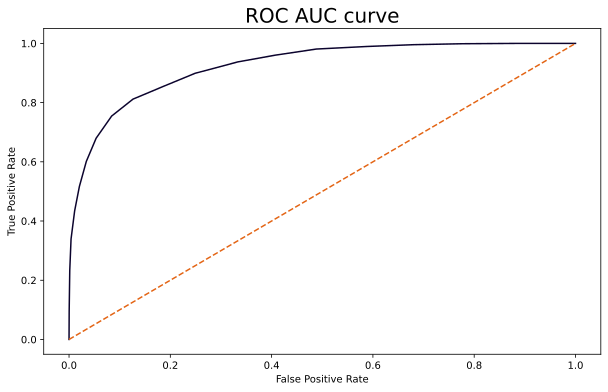

In [101]:
roc_auc(y_train_prob, y_train)

'ROC AUC score = 0.8063'

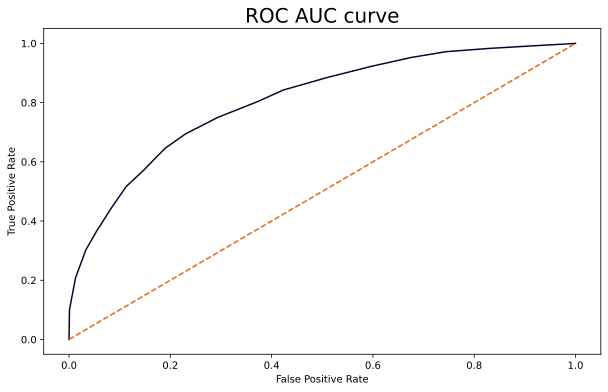

In [102]:
roc_auc(y_test_prob, y_test)

In [103]:
# модель XGBClassifier

xgb = XGBClassifier(n_estimators=300,
                    boosting_type='dart',
                    max_depth=4,
                    learning_rate=0.2,
                    class_weight = {0:1, 1:disbalance},
                    random_state=21)

xgb.fit(X_train, y_train)

y_train_prob  = xgb.predict_proba(X_train)[:, 1]
y_test_prob = xgb.predict_proba(X_test)[:, 1]

get_report(y_train, y_train_prob, y_test, y_test_prob)

[23:11:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { boosting_type, class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:11:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN: 0.9980097096056654
TEST:  0.8068348571554667


In [ ]:
Для финального предсказания выберем модель CatBoost

In [104]:
cv_score = cross_val_score(catb, X, y, scoring='roc_auc',
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.81095131, 0.8210764 , 0.84574061, 0.83914994, 0.80656283])

In [117]:
cv_score.mean()

0.8246962152595279

Метрика ROC_AUC получилась 0.825 в среднем по кросс-валидации для нашей модели. 

In [87]:
# Посмотрим на важность признаков с помощью permutation_importance

r = permutation_importance(catb, X, y,
                            n_repeats=30,
                            random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{FEATURES[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

topic_11 0.130 +/- 0.003
topic_1  0.072 +/- 0.003
topic_16 0.050 +/- 0.002
mean_spent_for_a_week 0.043 +/- 0.002
topic_5  0.036 +/- 0.002
topic_3  0.028 +/- 0.001
topic_10 0.023 +/- 0.002
topic_19 0.021 +/- 0.002
topic_12 0.020 +/- 0.002
topic_22 0.019 +/- 0.002
topic_4  0.018 +/- 0.002
topic_0  0.018 +/- 0.002
topic_15 0.017 +/- 0.002
expencive 0.012 +/- 0.002
topic_24 0.012 +/- 0.001
topic_6  0.011 +/- 0.001
more_than_median 0.011 +/- 0.001
median_purchase 0.011 +/- 0.001
min_spent_for_a_month 0.010 +/- 0.001
topic_9  0.010 +/- 0.001
max_income_for_a_month 0.010 +/- 0.001
topic_23 0.010 +/- 0.002
topic_8  0.010 +/- 0.001
topic_7  0.010 +/- 0.001
topic_2  0.009 +/- 0.001
topic_21 0.009 +/- 0.002
max_spent_for_a_month 0.009 +/- 0.001
topic_14 0.009 +/- 0.001
number_of_expensive 0.008 +/- 0.001
topic_17 0.008 +/- 0.001
mean_spent_for_a_month 0.007 +/- 0.001
min_spent_for_a_week 0.006 +/- 0.001
max_spent_for_a_week 0.005 +/- 0.001
topic_20 0.003 +/- 0.001
topic_13 0.003 +/- 0.001
topic_1

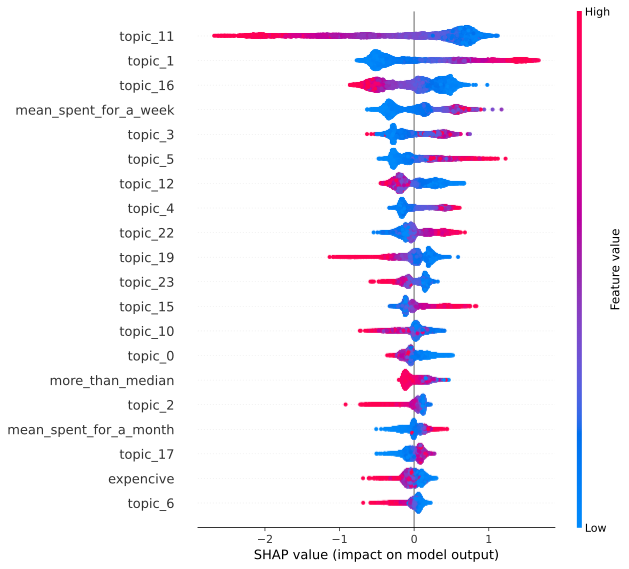

In [90]:
# И с помощью векторов Шепли

model = catb.fit(X[FEATURES].fillna(99999), y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[FEATURES].fillna(99999))
shap.summary_plot(shap_values, X[FEATURES])

Видно, что большинство признаков неплохо разделяют классы, снова видно, что самое сильное влияние оказывает векторное представнение пользователя

### Предсказание на всей выборке, сохранение модели 

In [108]:
X = full_train[FEATURES]
test = full_test[FEATURES]
y= full_train[TARGET]

In [109]:
X.shape, y.shape, test.shape

((8400, 37), (8400,), (3600, 37))

In [110]:
catb = CatBoostClassifier(learning_rate=0.08,
                          n_estimators=350,
                          depth=4,
                          class_weights=[1, disbalance],
                          silent=True,                           
                          random_state=21)

catb.fit(X, y)

full_test['gender'] = catb.predict_proba(test)[:, 1]

In [111]:
full_test['customer_id'] = full_test['customer_id'].astype(int)
test_id = pd.merge(test_id, full_test[['customer_id', 'gender']], on='customer_id', how='left')
test_id.drop(columns='probability', inplace=True)
test_id.rename(columns={'gender':'probability'}, inplace=True)

test_id

,customer_id,probability
0,75562265,0.446378
1,84816985,0.501112
2,54129921,0.281455
3,23160845,0.276515
4,45646491,0.139024
...,...,...
3595,89647691,0.255277
3596,53818229,0.713105
3597,88924303,0.206189
3598,28118312,0.284419


In [112]:
test_id.to_csv('Sokolova_predictions.csv', index=False, encoding='utf-8', sep=',')
test_id.head(10)

,customer_id,probability
0,75562265,0.446378
1,84816985,0.501112
2,54129921,0.281455
3,23160845,0.276515
4,45646491,0.139024
5,37245184,0.484421
6,67480620,0.125812
7,74041795,0.016680
8,19635150,0.533070
9,24825702,0.964269


### Сохранение модели

In [116]:
pickle.dump(catb, open(MODEL_FILE_PATH, "wb"))